![](https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png)

# *Neural Style Transfer* con pyTorch

## Aprendizaje Automático Aplicado

### Maestría en Ciencia de Datos

#### **Julio Waissman**, 2024

[**Abrir en google Colab**](https://colab.research.google.com/github/mcd-unison/aaa-curso/blob/main/ejemplos/nst_pytorch.ipynb)


Esta libreta está enteramente tomado de [este tutorial de pythorch](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cad5020cab595c3bf83a518b7e4d4125/neural_style_tutorial.ipynb) pero quité algunas explicaciones y agregué otras que me hubiera gustado tener a mi. Puedes ejecutar cualquiera de las libretas (la original o esta), asumiendo que la otra está mejor explicada.

Si quieres usar solamente el NST, entonces te recomiendo le pegues un ojo a [esta entrada de Medium](https://medium.com/geekculture/a-lightweight-pytorch-implementation-of-neural-style-transfer-86603e5eb551)


Vamos entonces cargando modulos


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

# Para esto vamos a necesitar GPU o no acabamos nunca
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## 1. Cargando las imágenes y visualizandolas

Aqui vamos a bajar una imagen de contenido (**C**) y una de estilo (**S**), que vamos a usar para combinarlas en una nueva (hay que ajustar su tamaño a lo que usa el modelo [VGG19](https://arxiv.org/abs/1409.1556).

In [10]:
!curl https://raw.githubusercontent.com/nazianafis/Neural-Style-Transfer/main/data/content-images/c1.jpg -o content.jpg
!curl https://raw.githubusercontent.com/nazianafis/Neural-Style-Transfer/main/data/style-images/s1.jpg -o style.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 68324  100 68324    0     0   289k      0 --:--:-- --:--:-- --:--:--  290k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  289k  100  289k    0     0  1417k      0 --:--:-- --:--:-- --:--:-- 1418k


In [18]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./style.jpg")
content_img = image_loader("./content.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Y vamos a visualizar las imagenes

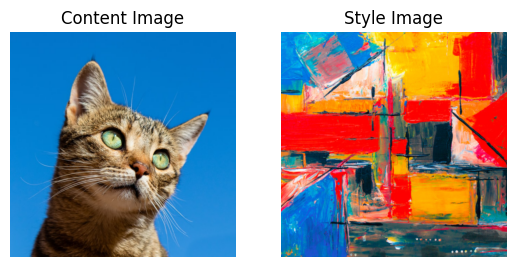

In [24]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)


plt.figure()
plt.subplot(1,2,1)
imshow(content_img, title='Content Image')
plt.subplot(1,2,2)
imshow(style_img, title='Style Image')



## 2. Funciones de pérdida


### Funcion de pérdida de contenido

In [25]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

**Nota del equipo de pyTorch**:

> Although this module is named <code>ContentLoss</code>, itis not a true
> PyTorch Loss function. If you want to define your contentloss as a
> PyTorch Loss function, you have to create a PyTorch autograd function
> to recompute/implement the gradient manually in the `backward method`.


### Funcion de pérdida de estilo

Este es un poco más complicada ya que se mide por la covarianza de las matrices de Gram de cada capa, así que primero hacemos una funcion para calgular las matrices y luego otra que calcula la pérdida.



In [26]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [27]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## 3. Modelo de evaluación de imagen de salida

Vamos primero a bajar el modelo VGG19. Fijense que el modelo lo cargamos solo para evaluación, por lo que sus pesos no se van a modificar.

In [28]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 89.3MB/s]


Si revisamos la [documentación del modelo VGG19 en torchvision](https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg19.html#torchvision.models.vgg19), dice esto:

> The inference transforms are available at VGG19_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

Por lo que tenemos que recortar y normalizar las imágenes para usar este modelo:

In [29]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

Y creamos el modelo para evaluar la pérdida en contenido y en estilo.

- Para contenido vamos a usar solo la capa convolucional 4
- Para estilo vamos a usar las capas convolucionales 1, 2, 3, 5 y 5



In [30]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Vamos a crear una función que devuelva 3 objetos:

1. El modelo para evaluar una imagen objetivo
2. La funcion de pérdida de contenido para una imagen de contenido particular
3. La funcion de pérdida de estilo para una imagen de estilo particular

Esta función esta complicada y es el corazón del modelo, hay qye verla con cuidado

In [32]:
def get_style_model_and_losses(
    cnn,
    normalization_mean, normalization_std,
    style_img,
    content_img,
    content_layers=content_layers_default,
    style_layers=style_layers_default
    ):

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to content/style losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

## 4. Inicializando el modelo objetivo

Empezamos con el mismo de contenido y de ahí modificamos, para no tardar tanto

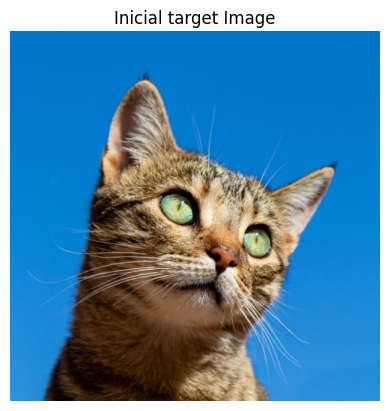

In [34]:
input_img = content_img.clone()
# Si quieres empezar con una imagen de ruido blanco usa esto:
# input_img = torch.randn(content_img.data.size())

plt.figure()
imshow(input_img, title='Inicial target Image')

## 5. Funciones de entrenamiento (ajuste de imagen)

Vamos a usar un método muy eficiente aunque costoso de optimización, el LBFGS (para mayor explicacion del método en [este enlace de wikipedia](https://en.wikipedia.org/wiki/Limited-memory_BFGS)).

In [35]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

Y ahora si el chuqui de todo este asunto

In [36]:
def run_style_transfer(
    cnn,
    normalization_mean, normalization_std,
    content_img,
    style_img,
    input_img,
    num_steps=300,
    style_weight=1000000,
    content_weight=1
    ):

    """Run the style transfer."""
    print('Building the style transfer model..')

    model, style_losses, content_losses = get_style_model_and_losses(
        cnn,
        normalization_mean, normalization_std,
        style_img,
        content_img
    )

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)

    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizando..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            # Gradientes a 0
            optimizer.zero_grad()

            # Calcula los gradientes y los errores de cada capa
            model(input_img)
            style_score = 0
            content_score = 0

            # Agrega las pérdidas de estilo y de contenido por capas
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            # Importancia de contenido y estilo
            style_score *= style_weight
            content_score *= content_weight

            # Calcula la pérdida conjunta
            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            # Cada 50 epochs
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

## 6. Ejecutando el algoritmo

In [41]:
input_img = content_img.clone()
output = run_style_transfer(
    cnn,
    cnn_normalization_mean, cnn_normalization_std,
    content_img,
    style_img,
    input_img,
    num_steps=300,
    style_weight=1000000,
    content_weight=100
)

Building the style transfer model..
Optimizando..
run [50]:
Style Loss : 2047.677490 Content Loss: 2143.088867

run [100]:
Style Loss : 570.249512 Content Loss: 2046.176147

run [150]:
Style Loss : 1004.406860 Content Loss: 2073.598389

run [200]:
Style Loss : 549.224731 Content Loss: 2518.086914

run [250]:
Style Loss : 395.073364 Content Loss: 1980.770508

run [300]:
Style Loss : 408.148407 Content Loss: 2141.414551



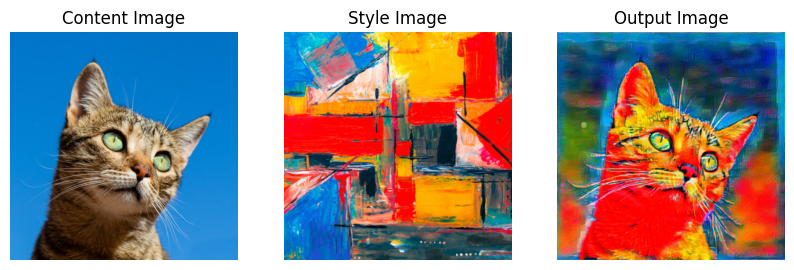

In [43]:
plt.figure(figsize=(10, 30))
plt.subplot(1,3,1)
imshow(content_img, title='Content Image')
plt.subplot(1,3,2)
imshow(style_img, title='Style Image')
plt.subplot(1,3,3)
imshow(output, title='Output Image')